# curated by Kashish Gupta (Masters in Quantitative Student at UCLA)

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf

## PAIR TRADING STRATEGY - COKE AND PEPSI using GBM

In [4]:
# get PEPSI AND COKE data 

pepsi = yf.download('PEP')['Adj Close']
coke = yf.download('KO')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'daily price movement of pepsi and coke')

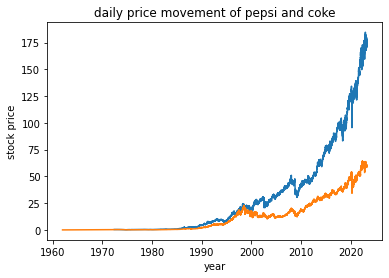

In [6]:
# visualize the daily movement of stock prices for both these stocks to check if they move together 
import matplotlib.pyplot as plt
plt.plot(pepsi)
plt.plot(coke)
plt.xlabel('year')
plt.ylabel('stock price')
plt.title('daily price movement of pepsi and coke')

Text(0.5, 1.0, 'Pepsi Log Returns')

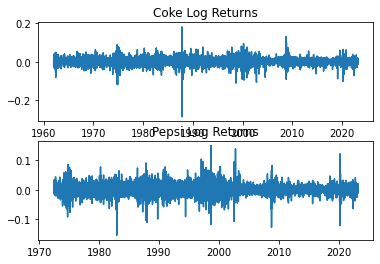

In [7]:
# get returns for both pepsi and coke 

import numpy as np
coke_returns = np.log(coke/coke.shift(1)).dropna()   # calculate log returns 

import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)  # a grid with 2 rows and 1 column and selecting the first subplot
plt.plot(coke_returns)
plt.title('Coke Log Returns')


pepsi_returns = np.log(pepsi/pepsi.shift(1)).dropna()  # calculate log returns 
plt.subplot(2,1,2)
plt.plot(pepsi_returns)
plt.title('Pepsi Log Returns')


Text(0.5, 1.0, 'Pepsi volatility')

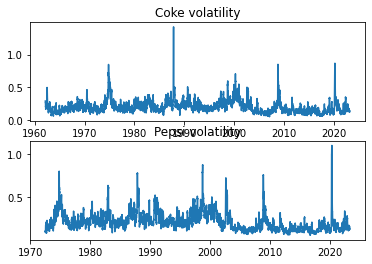

In [8]:
# calculate volitality using rolling window approach - smoothens out short-term fluctuations

rolling_window = 21
pepsi_vol = pepsi_returns.rolling(window = rolling_window).std() * np.sqrt(252) # gives annualized - 252 trading days in a year 
coke_vol = coke_returns.rolling(window = rolling_window).std() * np.sqrt(252)

plt.subplot(2,1,1)
plt.plot(coke_vol)
plt.title('Coke volatility')

plt.subplot(2,1,2)
plt.plot(pepsi_vol)
plt.title('Pepsi volatility')


In [9]:
# find correlation between these stocks 

corr = pepsi_returns.corr(coke_returns)
print('the correlation is:',corr)

# clearly these are correlated and we can develop a pair trading strategy 

the correlation is: 0.5310388012460565


### generate GBM path for both the stocks

In [10]:
# today's stock price 

list_stock = ['coke', 'pepsi']
data = {} # this creates a dictionary 
for i in list_stock: 
  i_today = locals()[i][-1]
  i_vol_today = locals()[i + '_vol'][-1]

  # store values in a dictionary 
  data[i+ '_today'] = i_today
  data[i+'_vol_today'] = i_vol_today

# extract values 
coke_today = data['coke_today']
pepsi_today = data['pepsi_today']
coke_vol_today = data['coke_vol_today']
pepsi_vol_today = data['pepsi_vol_today']

t = 1   # we want to simulate values upto 1 year 
n_time_intervals = 100 # discretize 
n_simulations = 100 # number of simulations 
mu = 0.1 # drift coefficient 

In [11]:
# simulating GBM path 

# calculate each time step 
dt = t/n_time_intervals

In [12]:
# simulations using numpy array for each stock 


St_pepsi = np.exp(
    (mu -((pepsi_vol_today**2)/2))*dt
    + pepsi_vol_today * np.random.normal(0, np.sqrt(dt), size = (n_simulations,n_time_intervals )).T
)

St_coke = np.exp(
    (mu -((coke_vol_today**2)/2))*dt
    + coke_vol_today * np.random.normal(0, np.sqrt(dt), size = (n_simulations,n_time_intervals )).T
)

In [13]:
# include arrays of 1s
St_pepsi = np.vstack([np.ones(n_simulations), St_pepsi])
St_coke = np.vstack([np.ones(n_simulations), St_coke])

In [14]:
# multiply through intiial value to get and get cummulative product of elements along a given simulation path 

St_pepsi = pepsi_today*St_pepsi.cumprod(axis =0)
St_coke = coke_today*St_coke.cumprod(axis =0)

In [15]:
# consider time intervals in years 

time = np.linspace(0, t, n_time_intervals + 1)

# same shape at St
tt = np.full(shape = (n_simulations,n_time_intervals +1 ), fill_value = time).T

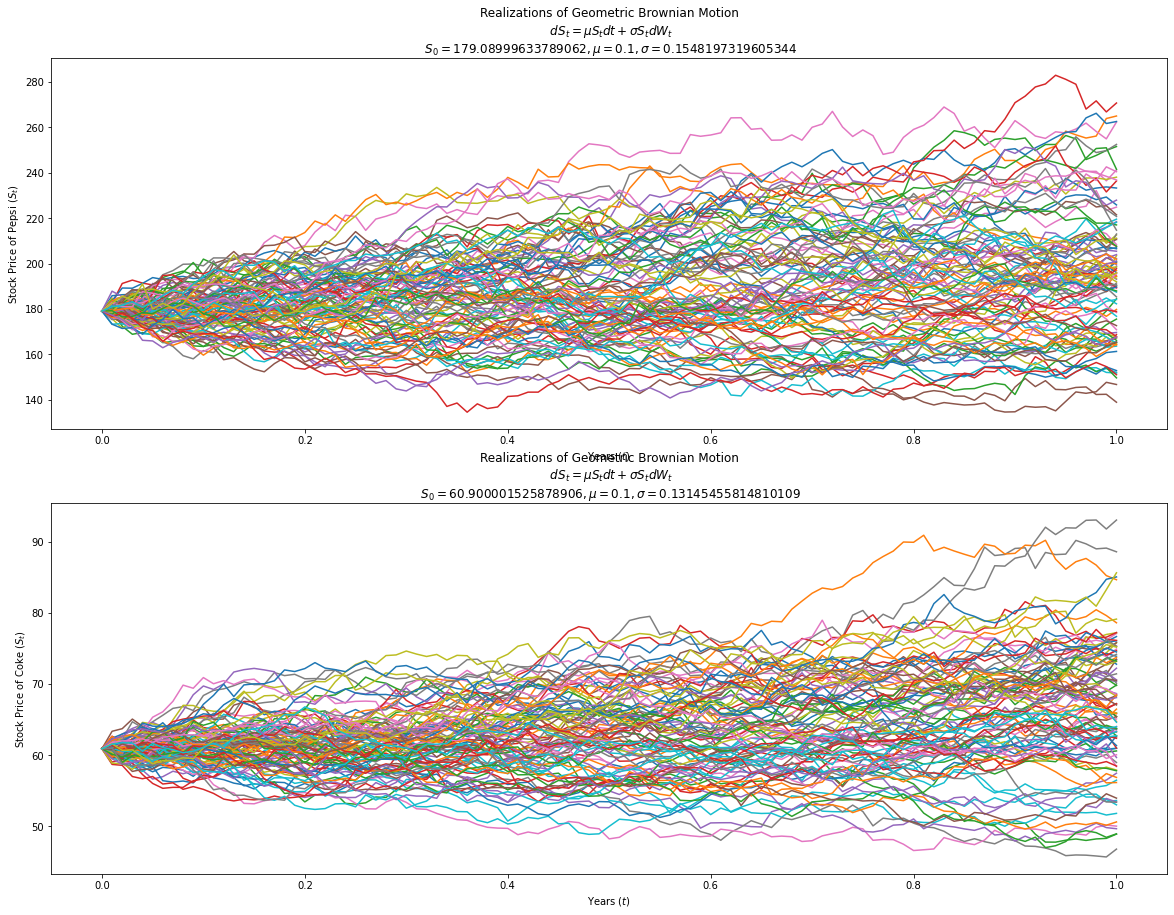

In [140]:
# plot the graph
plt.figure(figsize = (20,15))
plt.subplot(2,1,1)
plt.plot(tt, St_pepsi)
plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price of Pepsi $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(pepsi_today, mu, pepsi_vol_today)
)
plt.subplot(2,1,2)
plt.plot(tt, St_coke)

plt.xlabel("Years $(t)$")
plt.ylabel("Stock Price of Coke $(S_t)$")
plt.title(
    "Realizations of Geometric Brownian Motion\n $dS_t = \mu S_t dt + \sigma S_t dW_t$\n $S_0 = {0}, \mu = {1}, \sigma = {2}$".format(coke_today, mu, coke_vol_today)
)



plt.show()

### trading strategy

In [23]:
# calculate spread between the paths
import pandas as pd
spread = St_pepsi - St_coke
spread_df = pd.DataFrame(spread)
spread_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,...,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995,118.189995
1,125.997531,119.391054,118.215619,116.880861,118.739072,121.118292,117.914695,116.183444,113.412906,117.360869,...,112.145353,117.181896,119.116357,115.403519,115.011981,120.207491,120.717784,119.864769,120.964518,119.496101
2,126.346223,117.986919,111.310302,116.654213,119.512258,121.525248,117.583980,118.641685,109.474981,115.996629,...,109.461914,117.308767,116.743697,117.391050,112.740515,121.494665,119.112337,126.027298,124.962682,119.836400
3,128.056272,116.630395,106.559576,117.009706,120.325595,122.359564,118.164269,118.686725,112.039885,119.547754,...,108.959509,117.752465,116.345891,114.870577,108.740157,127.291698,118.980596,129.174837,123.149179,121.538204
4,130.388160,114.456244,107.437691,114.328996,122.356835,124.461504,122.276810,113.258607,112.254066,120.926405,...,104.410936,115.255637,116.484746,110.020891,102.541924,126.648061,125.293783,127.868858,131.342610,120.167868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,133.788167,99.670968,125.411255,139.425484,141.763137,128.023695,167.548838,100.916587,121.345006,151.203247,...,130.201173,129.803681,128.562389,93.041915,110.099369,102.574932,178.709961,114.407231,120.458541,117.791218
97,137.555000,101.819984,123.276299,142.073684,137.375437,130.831807,163.919217,104.685178,122.367379,158.014847,...,126.970541,132.486352,130.124241,95.464287,107.459698,101.274457,180.118881,115.750988,118.881805,111.555904
98,140.894005,97.446156,126.625776,147.569656,133.727965,127.207667,165.407339,104.113336,120.852666,154.299510,...,128.287037,134.278217,135.542280,97.680082,103.834397,104.436301,179.268629,115.548625,120.446193,113.891013
99,141.752765,99.693179,130.822625,143.341075,135.353258,131.222018,160.242565,105.431715,118.263873,156.749475,...,125.569669,137.989515,131.105109,95.528820,103.917507,106.855156,178.876599,117.116206,111.216380,117.046824


In [24]:
# compute rolling mean and rolling standard deviation 


rolling_window = 21 # number of trading days in a month 
spread_mean = spread_df.rolling(window = rolling_window).mean()
spread_std = spread_df.rolling(window = rolling_window).std()

In [30]:
spread_mean.iloc[:,0].isnull().sum()

# 20 out of 101 rows are nulls - makes sense 

20

In [32]:
# compute z-score of the spread 

z_score = (spread_df - spread_mean) / spread_std
z_score

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.656171,-2.172876,2.633248,1.444737,0.173106,-0.116444,2.387297,-1.025747,0.514710,1.777457,...,-0.994858,1.660213,-0.604886,0.744312,1.087727,-1.086486,1.426983,-0.752458,-1.386328,-1.482988
97,-0.157698,-1.351275,1.864421,1.792895,-0.476356,0.332290,1.504158,-0.496130,0.889951,2.328105,...,-1.286665,1.979137,-0.251173,1.108399,0.385533,-1.255009,1.512017,-0.271061,-1.537986,-2.046944
98,0.363416,-2.310650,2.113772,2.368171,-0.968825,-0.461332,1.569135,-0.499940,0.590925,1.625136,...,-1.020669,2.040417,0.940058,1.467545,-0.510036,-0.665684,1.252642,-0.388737,-1.134336,-1.608431
99,0.653961,-1.496199,2.313687,1.467165,-0.648430,0.319386,0.619218,-0.212016,-0.136069,1.738876,...,-1.236520,2.256930,-0.043353,0.940956,-0.571161,-0.075984,1.097788,0.202889,-2.432069,-1.081732


In [40]:
threshold_multiple = 2
upper_threshold = spread_mean + threshold_multiple*spread_std
lower_threshold = spread_mean - threshold_multiple*spread_std

# Convert the thresholds to z-scores
upper_z_score = (upper_threshold - upper_threshold.mean()) /  upper_threshold.std()
lower_z_score = (lower_threshold - lower_threshold.mean()) / lower_threshold.std()

In [48]:
lower_z_score

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.149323,-0.943517,0.596668,0.676030,-0.235901,-0.588367,1.759133,-0.578029,0.158957,1.639934,...,0.281702,0.875975,1.746940,0.148719,1.511817,-1.804203,0.942680,-0.060638,-0.522461,-1.783416
97,-0.065295,-1.019050,0.559162,1.004756,-0.261807,-0.450821,1.738135,-0.510280,0.252217,1.544850,...,0.156499,1.034248,1.757741,0.354296,1.534586,-1.761406,0.957954,-0.008315,-0.590536,-2.018971
98,0.087266,-1.337871,0.500074,0.958911,-0.321081,-0.400249,1.767237,-0.408439,0.316608,1.606838,...,0.079041,1.111517,1.759120,0.676857,1.517294,-1.672045,1.021791,0.029818,-0.616713,-2.132293
99,0.295578,-1.515674,0.366760,1.092655,-0.349575,-0.324331,1.827392,0.030249,0.312764,1.653211,...,-0.022952,1.076764,1.748670,0.919476,1.624913,-1.554093,1.096214,0.086198,-0.824645,-2.229078


In [59]:
# compare value 

# Compare the first columns


# Print the boolean mask
print(z_score.iloc[:, 0] > upper_z_score.iloc[:, 0])


0      False
1      False
2      False
3      False
4      False
       ...  
96     False
97     False
98     False
99      True
100     True
Name: 0, Length: 101, dtype: bool


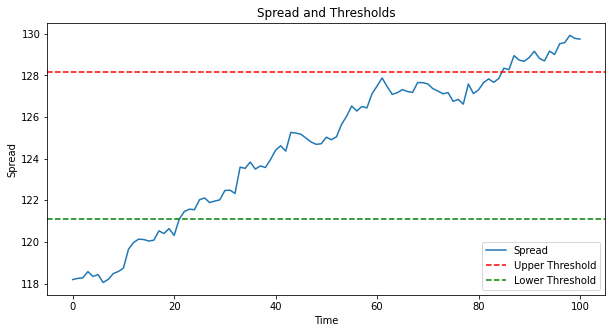

In [43]:
# plot thresholds and spread - we will visualize average path 

# Calculate the mean and standard deviation of the simulated prices
coke_mean = np.mean(St_coke, axis=1)
coke_std = np.std(St_coke, axis=1)

pepsi_mean = np.mean(St_pepsi, axis=1)
pepsi_std = np.std(St_pepsi, axis=1)

# spread 
spread_average = pepsi_mean - coke_mean
spread_average_mean = spread_average.mean()
spread_average_std  = spread_average.std()
spread_average_z_score = (spread_average - spread_average_mean) / spread_average_std
threshold_multiple = 1 # a threshold multiple of 1 is a common choice for statistical arbitrage strategies that use mean reversion
spread_average_upper_threshold = spread_average_mean + threshold_multiple*spread_average_std
spread_average__lower_threshold = spread_average_mean - threshold_multiple*spread_average_std


# Plot the average path and the standard deviation
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(spread_average, label='Spread')
ax.axhline(spread_average_upper_threshold, color='red', linestyle='--', label='Upper Threshold')
ax.axhline(spread_average__lower_threshold, color='green', linestyle='--', label='Lower Threshold')

ax.set_title('Spread and Thresholds')
ax.set_xlabel('Time')
ax.set_ylabel('Spread')
ax.legend()
plt.show()

In [87]:
# implement trading strategy 
# if z-score > upper threshold then short pepsi and long coke 

# initialize positions 
T = 100
coke_position = pd.DataFrame(index=z_score.index, columns=z_score.columns)
pepsi_position = pd.DataFrame(index=z_score.index, columns=z_score.columns)



In [ ]:

    elif np.all(z_score.iloc[i,:] < lower_z_score.iloc[i,:]):
        coke_position.iloc[i,:] = -1
        pepsi_position.iloc[i,:] = 1

    else:
        coke_position.iloc[i,:] = 0
        pepsi_position.iloc[i,:] = 0

In [93]:

# implement trading strategy 
# if z-score > upper threshold then short pepsi and long coke 
# if z-score < lower threshold then short coke and long pepsi 

for i in range(1, T):
    for j in range(z_score.shape[1]):
        if z_score.iloc[i,j] > upper_z_score.iloc[i,j]:
            coke_position.iloc[i,j] = 1
            pepsi_position.iloc[i,j] = -1
        elif z_score.iloc[i,j] < lower_z_score.iloc[i,j]:
            coke_position.iloc[i,j] = -1
            pepsi_position.iloc[i,j] = 1
        else:
            coke_position.iloc[i,j] = 0
            pepsi_position.iloc[i,j] = 0


In [102]:
# now compute returns for each stock 
coke_returns = np.diff(St_coke) / St_coke[:,:-1]
pepsi_returns = np.diff(St_pepsi) / St_pepsi[:,:-1]

In [111]:
# total returns 

total_returns = ((coke_position.iloc[:,:-1]) *coke_returns)+ ((pepsi_position.iloc[:,:-1])*pepsi_returns)

In [130]:
# cummulative returns 

cumulative_returns = np.cumprod(1 + total_returns, axis=1) - 1

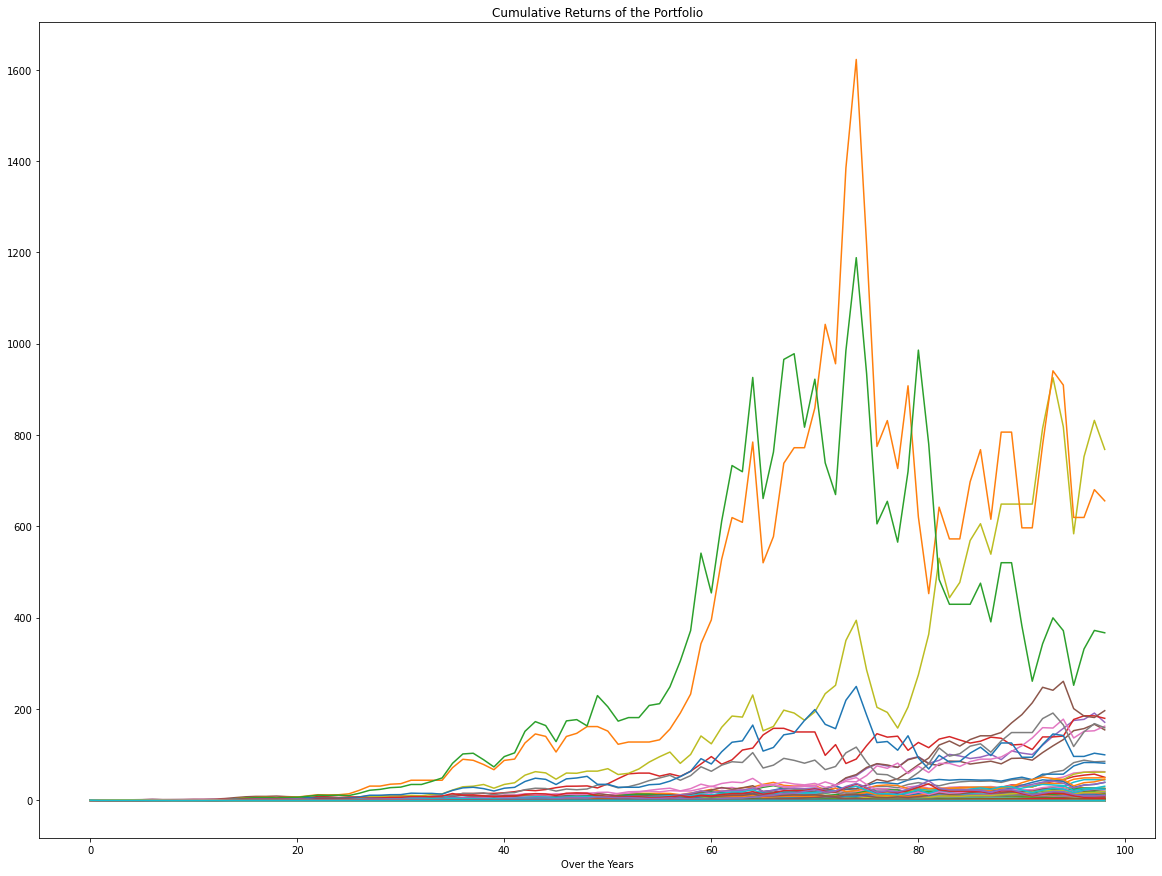

In [139]:
# now graph 


# plot cumulative returns against years
plt.figure(figsize = (20,15))
plt.plot(cumulative_returns.T)

# set x-axis label and title
plt.xlabel('Over the Years')
plt.title('Cumulative Returns of the Portfolio')

# show the plot
plt.show()